In [1]:
import numpy as np
import pandas as pd
import warnings   
warnings.filterwarnings("ignore")

from sklearn.metrics import recall_score, classification_report, accuracy_score, confusion_matrix, r2_score
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, train_test_split

from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.wrappers.scikit_learn import KerasClassifier

import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras.models import load_model
from joblib import dump, load

# load your data into a pandas dataframe
df = pd.read_csv('df_w_attributes.csv')

# split the data into features (X) and target (y)
X = df.drop(columns=['Address','FLAG']).values
y = df['FLAG'].values

In [131]:
def FNR_calc(mat):
    tn = mat[0,0]
    tp = mat[1,1]
    fn = mat[1,0]
    fp = mat[0,1]
    print(f'tn: {tn}, fp: {fp},\nfn: {fn},   tp: {tp}')
    print(f'FNR: {round(fn/(fn+tp) * 100, 2)}%')
    print(f'Recall: {round(tp/(fn+tp) * 100, 2)}%')
    print(f'Precision: {round(tp/(fp+tp) * 100, 2)}%')
    return fn/(fn+tp)

def matrix_plotter(mat):
    ax = sns.heatmap(mat, annot=True, cmap='Blues', fmt='g')
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    ax.xaxis.set_ticklabels(['False','True'])
    ax.yaxis.set_ticklabels(['False','True'])
    plt.show()

## All addresses

#### LSTM

In [75]:
# define the number of folds for k-fold cross validation
n_folds = 5

# define the LSTM model
model = Sequential()
model.add(LSTM(units=50, input_shape=(X.shape[1], 1)))
model.add(Dense(1, activation='sigmoid'))

# compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# define the k-fold cross validation split
kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

# initialize a list to store the recall scores for each fold
recall_scores = []

# loop through each fold
for train_index, test_index in kfold.split(X, y):
    # split the data into train and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # reshape the data for the LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # fit the model on the train data
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
    
    # make predictions on the test data
    y_pred = model.predict(X_test)
    y_pred_binary = (y_pred >= 0.5).astype(int)
    
    # calculate the recall score for this fold
    recall = recall_score(y_test, y_pred_binary)
    
    # store the recall score for this fold
    recall_scores.append(recall)

# calculate the mean and standard deviation of the recall scores
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

# print the results
print(f'Mean Recall Score: {mean_recall:.3f}')
print(f'Standard Deviation of Recall Scores: {std_recall:.3f}')
print(recall_scores)

181/181 [==============================] - 1s 7ms/step
Mean Recall Score: 0.857
Standard Deviation of Recall Scores: 0.018
[0.8384379785604901, 0.835375191424196, 0.8575803981623277, 0.8828483920367535, 0.8689655172413793]


In [76]:
# define number of folds
n_folds = 5

# create a KFold object
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# initialize a list to store the recall scores for each fold
recall_scores = []

# loop through the folds
for train_index, test_index in kfold.split(X, y):
    # split the data into train and test sets
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # reshape the data for the LSTM model
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    # define and fit the model
    model = Sequential()
    model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

    # make predictions on the test set
    y_pred = model.predict(X_test)

    # convert the predicted probabilities to binary labels
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]

    # calculate the recall score for this fold
    recall = recall_score(y_test, y_pred)

    # store the recall score for this fold
    recall_scores.append(recall)

# calculate the mean and standard deviation of the recall scores
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

print(f"Recall: {mean_recall:.3f} (+/- {std_recall:.3f})")
print(recall_scores)

91/91 [==============================] - 1s 7ms/step
Recall: 0.810 (+/- 0.026)
[0.8269525267993875, 0.8376722817764165, 0.7840735068912711, 0.7932618683001531, 0.7871362940275651, 0.8269525267993875, 0.8039816232771823, 0.8070444104134763, 0.7718223583460949, 0.8573619631901841]


In [77]:
print(f"Recall: {mean_recall:.3f} (+/- {std_recall:.3f})")
print(recall_scores)

Recall: 0.810 (+/- 0.026)
[0.8269525267993875, 0.8376722817764165, 0.7840735068912711, 0.7932618683001531, 0.7871362940275651, 0.8269525267993875, 0.8039816232771823, 0.8070444104134763, 0.7718223583460949, 0.8573619631901841]


#### XGBoost

In [91]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score

X = df.drop(columns = ['FLAG','Address'], axis=1)
y = df['FLAG']

# Initialize a list to store the recall scores for each fold
recall_scores = []

# Set up the cross validation object
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Iterate over each fold
for train_index, test_index in kfold.split(X, y):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Convert the data into DMatrix format, which is the input format for XGBoost
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    
    # Set up the XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
    }
    
    # Train the XGBoost model
    model = xgb.train(params, dtrain)
    
    # Make predictions on the test set
    y_pred = model.predict(dtest)
    
    # Convert the predictions from probability scores to binary labels
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]
    
    # Calculate the recall score for this fold
    recall = recall_score(y_test, y_pred)
    
    # Store the recall score for this fold
    recall_scores.append(recall)

# Calculate the mean and standard deviation of the recall scores
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

print(f'Mean recall score: {mean_recall:.3f}')
print(f'Standard deviation of recall score: {std_recall:.3f}')
print(recall_scores)

Mean recall score: 0.878
Standard deviation of recall score: 0.006
[0.8736600306278713, 0.885145482388974, 0.8843797856049005, 0.8767228177641654, 0.8681992337164751]


In [116]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score

X = df.drop(columns = ['FLAG','Address'], axis=1)
y = df['FLAG']

# Initialize a list to store the recall scores for each fold
recall_scores = []

# Set up the cross validation object
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Iterate over each fold
for train_index, test_index in kfold.split(X, y):
    # Split the data into training and testing sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    # Convert the data into DMatrix format, which is the input format for XGBoost
    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_test, y_test)
    
    # Set up the XGBoost parameters
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc'
    }
    
    # Train the XGBoost model
    model = xgb.train(params, dtrain)
    
    # Make predictions on the test set
    y_pred = model.predict(dtest)
    
    # Convert the predictions from probability scores to binary labels
    y_pred = [1 if p > 0.5 else 0 for p in y_pred]
    
    # Calculate the recall score for this fold
    recall = recall_score(y_test, y_pred)
    
    # Store the recall score for this fold
    recall_scores.append(recall)

# Calculate the mean and standard deviation of the recall scores
mean_recall = np.mean(recall_scores)
std_recall = np.std(recall_scores)

print(f'Mean recall score: {mean_recall:.3f}')
print(f'Standard deviation of recall score: {std_recall:.3f}')
print(recall_scores)

Mean recall score: 0.878
Standard deviation of recall score: 0.012
[0.8606431852986217, 0.877488514548239, 0.886676875957121, 0.8652373660030628, 0.8790199081163859, 0.8973966309341501, 0.891271056661562, 0.877488514548239, 0.8621745788667687, 0.8865030674846626]


#### MLP

In [42]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

# define the MLP model
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)

# separate the input features (X) and target label (y)
X = df.drop(columns = ['FLAG','Address'], axis=1)
y = df['FLAG']

# use cross-validation to evaluate the model's performance
scores = cross_val_score(mlp, X, y, cv=5, scoring='recall')

# print the mean and standard deviation of the recall scores
print(f'Mean recall score: {scores.mean():.3f}')
print(f'Standard deviation: {scores.std():.3f}')

Mean recall score: 0.549
Standard deviation: 0.197


In [70]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import recall_score
from sklearn.neural_network import MLPClassifier

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# initialize a list to store the recall scores for each fold
recall_scores = []

# loop through each fold
for train_index, test_index in kfold.split(X, y):
    # split the data into training and testing sets
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]

    # create an MLP model
    model = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=200)
    
    # fit the model on the training data
    model.fit(X_train, y_train)
    
    # make predictions on the testing data
    y_pred = model.predict(X_test)
    
    # calculate the recall score for this fold
    recall = recall_score(y_test, y_pred)
    
    # store the recall score for this fold
    recall_scores.append(recall)

# calculate the mean recall score across all folds
mean_recall = np.mean(recall_scores)
print(f'Mean recall score: {mean_recall:.3f}')
print(recall_scores)

Mean recall score: 0.242
[0.1807044410413476, 0.18683001531393567, 0.6156202143950995, 0.1807044410413476, 0.16232771822358347, 0.1807044410413476, 0.18529862174578868, 0.333843797856049, 0.17304747320061256, 0.21625766871165644]


In [71]:
# create an MLP model
model = MLPClassifier(hidden_layer_sizes=(100, 50, 25), max_iter=200)

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# initialize a list to store the recall scores for each fold
recall_scores = []

# loop through each fold
for train_index, test_index in kfold.split(X, y):
    # split the data into training and testing sets
    X_train, X_test = X.iloc[train_index, :], X.iloc[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    
    # fit the model on the training data
    model.fit(X_train, y_train)
    
    # make predictions on the testing data
    y_pred = model.predict(X_test)
    
    # calculate the recall score for this fold
    recall = recall_score(y_test, y_pred)
    
    # store the recall score for this fold
    recall_scores.append(recall)

# calculate the mean recall score across all folds
mean_recall = np.mean(recall_scores)
print(f'Mean recall score: {mean_recall:.3f}')
print(recall_scores)

Mean recall score: 0.239
[0.17611026033690658, 0.19142419601837674, 0.19142419601837674, 0.17457886676875958, 0.1562021439509954, 0.17304747320061256, 0.18529862174578868, 0.15926493108728942, 0.27105666156202146, 0.7116564417177914]


### Stack LSTM + XGBoost

In [ ]:
# Import the necessary modules
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Define the XGBoost model
xgb_model = XGBClassifier()

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(32, input_shape=(None, 1)))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define the stacking classifier
stacking_classifier = StackingClassifier(estimators=[('xgb', xgb_model), ('lstm', lstm_model)])

# Evaluate the stacked classifier using cross-validation
scoring = 'recall'
# scores = cross_val_score(stacking_classifier, X, y, cv=5, scoring = 'recall')
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Calculate the cross-validated score for the model
scores = cross_val_score(stacking_classifier, X, y, cv=skf, scoring=scoring)
print(scores)
print(np.mean(scores))

In [115]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasClassifier
from xgboost import XGBClassifier

# Define the LSTM model
def create_lstm_model(input_shape):
    model = Sequential()
    model.add(LSTM(64, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the LSTM model in a KerasClassifier
lstm_model = KerasClassifier(build_fn=create_lstm_model, input_shape=(X.shape[1],1), epochs=10, batch_size=64)

# Define the XGBoost model
xgb_model = XGBClassifier()

# Stack the two models using a pipeline
model = Pipeline([
    ('lstm', lstm_model),
    ('xgb', xgb_model)
])

# Evaluate the stacked model using cross validation
# scores = cross_val_score(model, X, y, cv=10, scoring='recall')
# print(scores)
# print(np.mean(scores))

# # Define the stacking classifier
# stacking_classifier = StackingClassifier(estimators=[('xgb', xgb_model), ('lstm', lstm_model)])


# # Evaluate the stacked classifier using cross-validation
# scoring = 'recall'
# # scores = cross_val_score(stacking_classifier, X, y, cv=5, scoring = 'recall')
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Calculate the cross-validated score for the model
# scores = cross_val_score(stacking_classifier, X, y, cv=skf, scoring=scoring)
# print(scores)
# print(np.mean(scores))

stacking_model = StackingClassifier(estimators=[('lstm', lstm_model), ('xgb', xgb_model)])

# Evaluate the stacked model using 10-fold cross-validation with the recall score as the evaluation metric
scores = cross_val_score(stacking_model, X, y, cv=10, scoring='recall')

# Print the mean and standard deviation of the recall scores
print(f'Mean recall score: {scores.mean():.3f}')
print(f'Standard deviation of the recall score: {scores.std():.3f}')

Epoch 1/10
406/406 [==============================] - 24s 42ms/step - loss: 0.3132 - accuracy: 0.8794
Epoch 2/10
406/406 [==============================] - 19s 47ms/step - loss: 0.2107 - accuracy: 0.9250
Epoch 3/10
406/406 [==============================] - 19s 47ms/step - loss: 0.1799 - accuracy: 0.9374
Epoch 4/10
406/406 [==============================] - 17s 43ms/step - loss: 0.1682 - accuracy: 0.9408
Epoch 5/10
406/406 [==============================] - 17s 42ms/step - loss: 0.1564 - accuracy: 0.9466
Epoch 6/10
406/406 [==============================] - 17s 42ms/step - loss: 0.1501 - accuracy: 0.9479
Epoch 7/10
406/406 [==============================] - 17s 42ms/step - loss: 0.1462 - accuracy: 0.9506
Epoch 8/10
406/406 [==============================] - 17s 42ms/step - loss: 0.1465 - accuracy: 0.9493
Epoch 9/10
406/406 [==============================] - 18s 43ms/step - loss: 0.1381 - accuracy: 0.9520
Epoch 10/10
406/406 [==============================] - 17s 42ms/step - loss: 0.135

### Testing XGBoost + LSTM individually

#### LSTM

In [200]:
from scikeras.wrappers import KerasClassifier

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=45, batch_size=64, verbose=0)

y_pred = model.predict(X_val)
y_pred_binary = (y_pred >= 0.5).astype(int)

91/91 [==============================] - 4s 29ms/step


In [218]:
y_pred = model.predict(X_val)
y_pred_binary = (y_pred >= 0.5).astype(int)

181/181 [==============================] - 8s 37ms/step


tn: 4401, fp: 96,
fn: 156,   tp: 1111
FNR: 12.31%
Recall: 87.69%
Precision: 92.05%


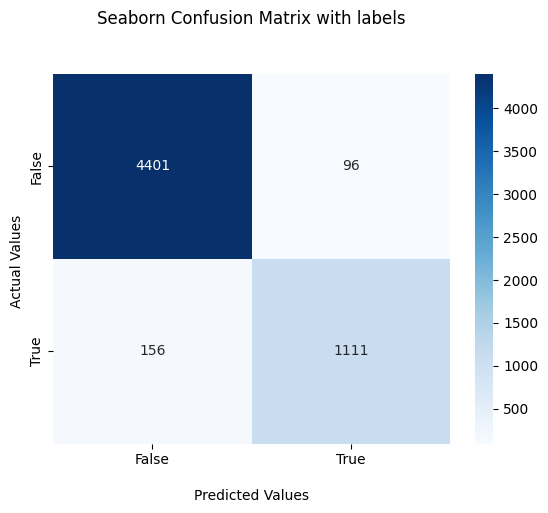

In [219]:
cf_matrix = confusion_matrix(y_val,y_pred_binary)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

##### Tests on different batch sizes

In [192]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=45, batch_size=256, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)

91/91 [==============================] - 4s 27ms/step


In [193]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=45, batch_size=128, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)

91/91 [==============================] - 4s 34ms/step
tn: 2170, fp: 60,
fn: 81,   tp: 571
FNR: 12.42%
Recall: 87.58%
Precision: 90.49%


0.12423312883435583

In [194]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=45, batch_size=64, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)

91/91 [==============================] - 4s 31ms/step
tn: 2180, fp: 50,
fn: 85,   tp: 567
FNR: 13.04%
Recall: 86.96%
Precision: 91.9%


0.1303680981595092

In [ ]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=45, batch_size=32, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)

In [ ]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=45, batch_size=16, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)

In [ ]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=100, batch_size=8, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)

In [ ]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=100, batch_size=4, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)

Conclusion - batch size 64 is the best from google colab
https://colab.research.google.com/drive/1k_fD9SkX2iLbgKOYptySrr8EV27fZU0A#scrollTo=hzqFopx4IXHL

##### Finding optimal epoch

Epoch 1/100
356/356 [==============================] - 46s 117ms/step - loss: 0.3733 - accuracy: 0.8470 - val_loss: 0.2552 - val_accuracy: 0.9719
Epoch 2/100
356/356 [==============================] - 40s 113ms/step - loss: 0.2779 - accuracy: 0.8954 - val_loss: 0.1655 - val_accuracy: 0.9795
Epoch 3/100
356/356 [==============================] - 44s 123ms/step - loss: 0.2348 - accuracy: 0.9147 - val_loss: 0.0559 - val_accuracy: 0.9907
Epoch 4/100
356/356 [==============================] - 41s 116ms/step - loss: 0.2127 - accuracy: 0.9216 - val_loss: 0.0646 - val_accuracy: 0.9888
Epoch 5/100
356/356 [==============================] - 41s 117ms/step - loss: 0.1993 - accuracy: 0.9278 - val_loss: 0.1400 - val_accuracy: 0.9607
Epoch 6/100
356/356 [==============================] - 42s 117ms/step - loss: 0.1892 - accuracy: 0.9303 - val_loss: 0.1240 - val_accuracy: 0.9758
Epoch 7/100
356/356 [==============================] - 43s 120ms/step - loss: 0.1812 - accuracy: 0.9344 - val_loss: 0.1610 -

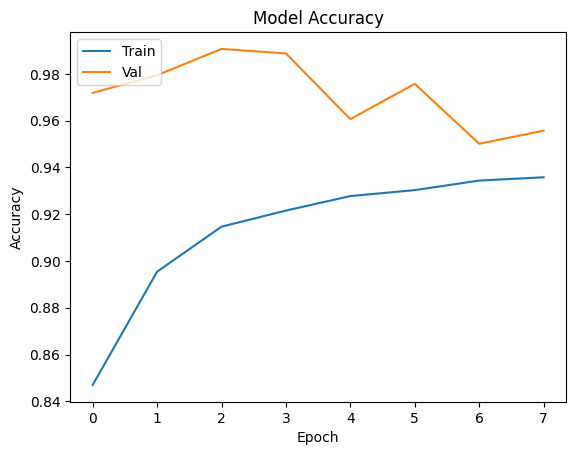

In [166]:
from keras.callbacks import EarlyStopping

# Define the model
model = Sequential()
# model.add(LSTM(units=50, input_shape=(X_train.shape[1], 1)))
# model.add(Dense(1, activation='sigmoid'))
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Fit the model using early stopping
history = model.fit(X, y, epochs=100, batch_size=64, validation_split=0.2, callbacks=[early_stopping])

# Plot the training and validation accuracy over the number of epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# Define the model
model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_recall', patience=5, restore_best_weights=True)

# Fit the model with early stopping
history = model.fit(X_train, y_train, epochs=100, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('Model Recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

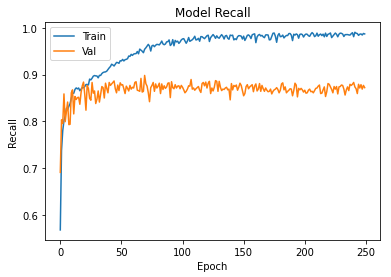

In [205]:
from PIL import Image
im = Image.open(r"lstm_optimal_epoch.png")
display(im)

#### XGBoost

In [222]:
# xgb_model = xgb.XGBClassifier(seed = 42)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
xgb_model = xgb.XGBClassifier(colsample_bytree= 0.5, gamma= 0.2, learning_rate= 0.2, max_depth= 4, min_child_weight= 6, scale_pos_weight= 7, eval_metric = 'logloss')
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_val)

tn: 4337, fp: 160,
fn: 46,   tp: 1221
FNR: 3.63%
Recall: 96.37%
Precision: 88.41%


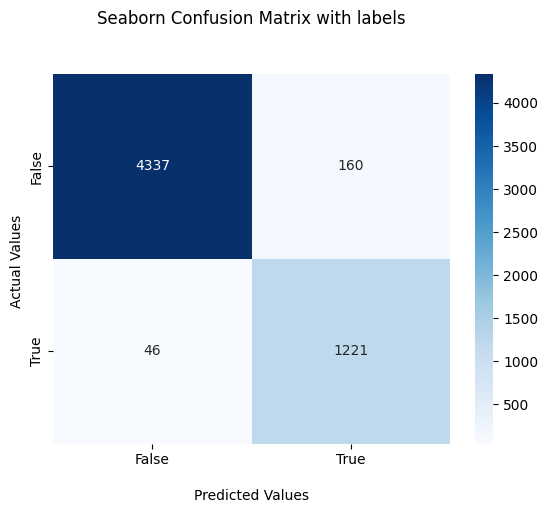

In [223]:
cf_matrix = confusion_matrix(y_val,xgb_pred)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

#### Merge XGBoost and LSTM

In [227]:
lstm_pred = [x[0] for x in y_pred_binary]
lstm_xgb_comparison = pd.DataFrame({'lstm': lstm_pred, 'xgb': xgb_pred, 'actual': y_val})

In [228]:
combined_lst = []
for i in range(len(lstm_pred)):
    if (lstm_pred[i]==0) and (xgb_pred[i]==0):
        combined_lst.append(0)
    else:
        combined_lst.append(1)

tn: 4285, fp: 212,
fn: 36,   tp: 1231
FNR: 2.84%
Recall: 97.16%
Precision: 85.31%


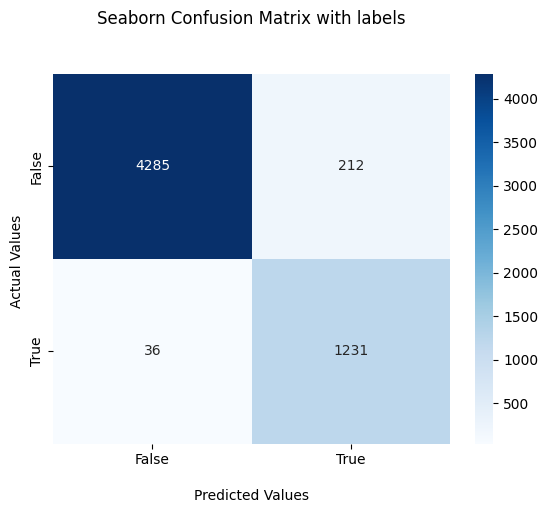

In [230]:
cf_matrix = confusion_matrix(y_val,combined_lst)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

## Only Addresses with <10k transactions

In [2]:
df_less_than_10k = df[df['txn_count'] < 10000].copy()
X = df_less_than_10k.drop(columns=['Address','FLAG']).values
y = df_less_than_10k['FLAG'].values

In [4]:
df_less_than_10k.shape

(28466, 24)

In [6]:
df_more_than_10k = df[df['txn_count'] >= 10000].copy()

In [11]:
df_more_than_10k[df_more_than_10k['FLAG'] == 1]

,Address,numerical_balance,txn_count,sent_txn,received_txn,total_ether_sent,max_ether_sent,min_ether_sent,average_ether_sent,max_ether_received,...,unique_sent_to_address,get_time_diff,mean_time_btw_received,mean_time_btw_sent,total_erc20_txns,erc20_total_ether_sent,erc20_total_ether_received,erc20_uniq_rec_addr,erc20_uniq_sent_addr,FLAG
2468,0x4ac6307a85d83962503f86457de9c331a6926f48,0.139202,10000,9010,990,802.793142,100.0,0.005000,0.08910,126.080000,...,3183,46322.76667,46.790673,1.667475,7,802.793142,1024.851662,6,0,1
4036,0xb2628597aac64b136c2aae3a516ea79a44817d77,0.259269,10000,376,9624,18796.566990,240.0,0.000943,49.99087,39.999979,...,57,606047.83330,62.979095,1615.717156,16,18796.566990,18803.975290,15,0,1
6525,0x83053c32b7819f420dcfed2d218335fe430fe3b5,0.000000,10000,9995,5,0.000000,0.0,0.000000,0.00000,10.000000,...,9960,59459.81667,2558.725000,5.942981,4,0.000000,14.070149,4,0,1


In [164]:
from scikeras.wrappers import KerasClassifier

model = Sequential()
model.add(LSTM(64, input_shape=(X.shape[1],1), return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[tf.keras.metrics.Recall()])
model.fit(X_train, y_train, epochs=10, batch_size=64, verbose=0)

y_pred = model.predict(X_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

91/91 [==============================] - 3s 28ms/step


tn: 2181, fp: 49,
fn: 120,   tp: 532
FNR: 18.4%
Recall: 81.6%
Precision: 91.57%


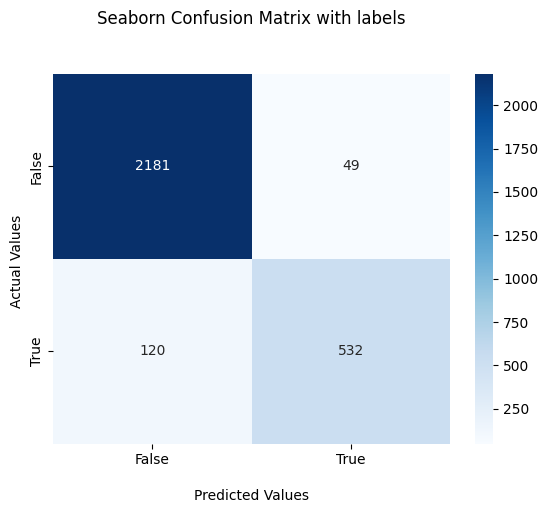

In [165]:
cf_matrix = confusion_matrix(y_test,y_pred_binary)
FNR_calc(cf_matrix)
matrix_plotter(cf_matrix)

## Exporting XGBoost and LSTM

In [213]:
model.save("lstm_train_data.h5")

In [215]:
from tensorflow.keras.models import load_model
new_lstm = load_model('lstm_train_data.h5')

In [236]:
from joblib import dump, load
dump(xgb_model, 'xgb_train_data.dat') 

In [ ]:
new_xgb = load('xgb_train_data.dat')